In [1]:
import os
import tqdm
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.utils.data as data
import torchvision.transforms as transforms
from torchvision import datasets
from torchvision.utils import make_grid

import warnings
warnings.filterwarnings('ignore')

/data/student/.conda/envs/snow/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


This warning does not affect the result.

In [2]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.layers(x)
        return x

In [3]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(784, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.layers(x)
        return x.view(-1)

In [4]:
cuda_id = 0
device_name = "cuda:{}".format(cuda_id) if torch.cuda.is_available() else "cpu"
device = torch.device(device_name)

In [5]:
epochs = 500
batch_size = 128
lr = 0.0002
latent_dim = 100

In [6]:
dataloader = data.DataLoader(
    datasets.MNIST('data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize(0.5, 0.5)
                   ])),
    batch_size=batch_size, shuffle=True)
generator = Generator().to(device)
discriminator = Discriminator().to(device)
optimizer_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
criterion = nn.BCELoss()

In [7]:
generator

Generator(
  (layers): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Linear(in_features=1024, out_features=784, bias=True)
    (12): Tanh()
  )
)

In [8]:
discriminator

Discriminator(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [9]:
def generate(generator, epoch):
    if not os.path.exists('img'):
        os.mkdir('img')
    if not os.path.exists('checkpoints'):
        os.mkdir('checkpoints')
    generator.eval()
    noise = torch.randn(64, latent_dim).to(device)
    with torch.no_grad():
        fake = generator(noise)
    fake = fake.view(-1, 1, 28, 28)
    img_grid_fake = make_grid(fake, normalize=True)
    plt.imshow(np.transpose(img_grid_fake.cpu(), (1, 2, 0)))
    plt.title(f'epoch {epoch} | fake images')
    plt.axis('off')
    plt.show()

  0%|          | 0/500 [00:00<?, ?it/s]

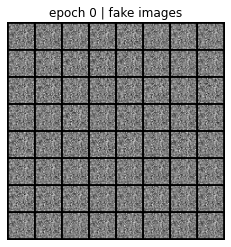

  4%|▍         | 19/500 [05:11<2:10:40, 16.30s/it]

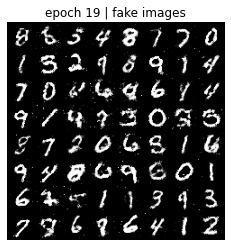

  8%|▊         | 39/500 [10:37<2:04:28, 16.20s/it]

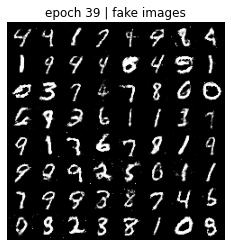

 12%|█▏        | 59/500 [16:04<2:00:29, 16.39s/it]

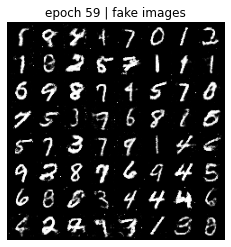

 16%|█▌        | 79/500 [21:32<1:52:06, 15.98s/it]

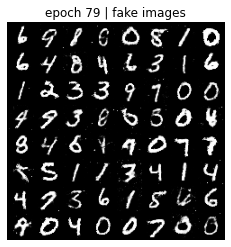

 20%|█▉        | 99/500 [26:56<1:50:00, 16.46s/it]

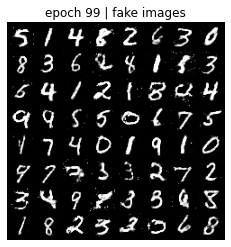

 24%|██▍       | 119/500 [32:19<1:41:56, 16.06s/it]

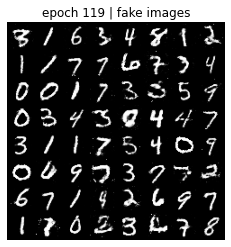

 28%|██▊       | 139/500 [37:47<1:38:40, 16.40s/it]

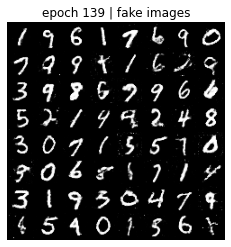

 32%|███▏      | 159/500 [43:16<1:34:24, 16.61s/it]

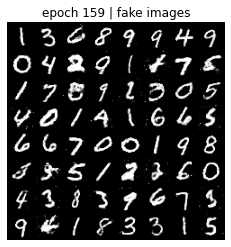

 36%|███▌      | 179/500 [48:41<1:26:01, 16.08s/it]

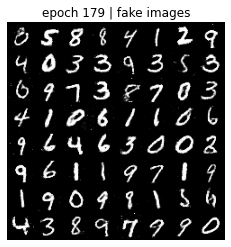

 40%|███▉      | 199/500 [54:07<1:21:57, 16.34s/it]

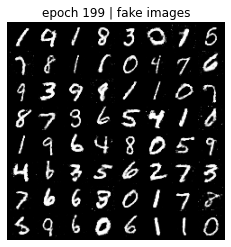

 44%|████▍     | 219/500 [59:44<1:18:53, 16.84s/it]

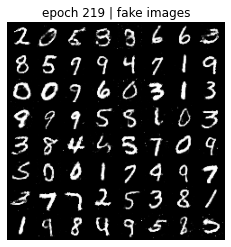

 48%|████▊     | 239/500 [1:05:10<1:10:32, 16.22s/it]

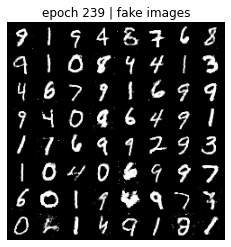

 52%|█████▏    | 259/500 [1:10:37<1:07:17, 16.75s/it]

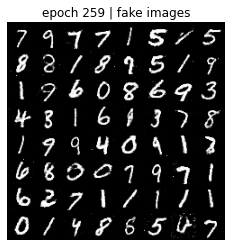

 56%|█████▌    | 279/500 [1:16:10<1:00:45, 16.49s/it]

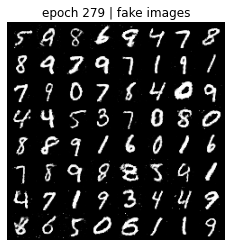

 60%|█████▉    | 299/500 [1:21:37<55:01, 16.43s/it]  

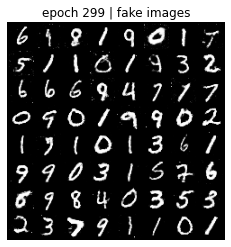

 64%|██████▍   | 319/500 [1:27:04<48:23, 16.04s/it]

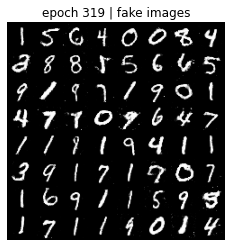

 68%|██████▊   | 339/500 [1:32:34<45:03, 16.79s/it]

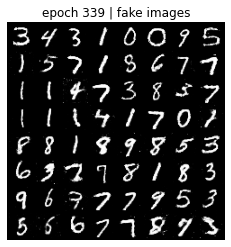

 72%|███████▏  | 359/500 [1:38:01<38:02, 16.19s/it]

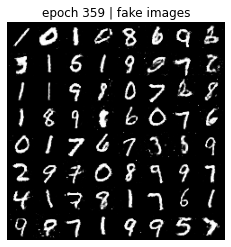

 76%|███████▌  | 379/500 [1:43:32<35:36, 17.66s/it]

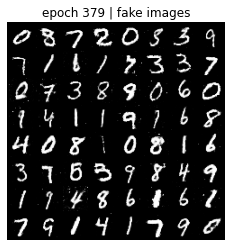

 80%|███████▉  | 399/500 [1:49:02<27:57, 16.61s/it]

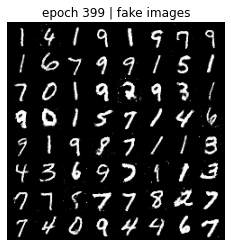

 84%|████████▍ | 419/500 [1:54:27<21:51, 16.19s/it]

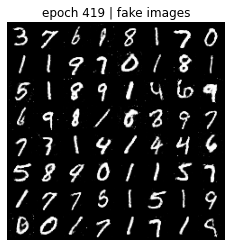

 88%|████████▊ | 439/500 [1:59:56<16:46, 16.50s/it]

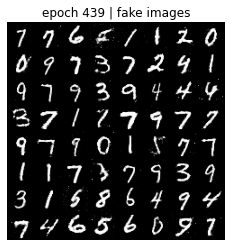

 92%|█████████▏| 459/500 [2:05:31<11:10, 16.36s/it]

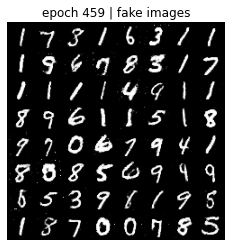

 96%|█████████▌| 479/500 [2:11:00<05:40, 16.23s/it]

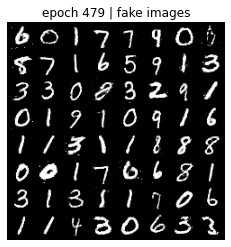

100%|█████████▉| 499/500 [2:16:32<00:16, 16.85s/it]

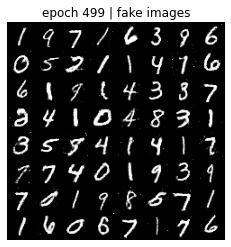

100%|██████████| 500/500 [2:16:48<00:00, 16.42s/it]


In [10]:
errors_d = []
errors_g = []
for epoch in tqdm.tqdm(range(epochs)):
    avg_error_d = 0
    avg_error_g = 0
    if epoch == 0 or (epoch + 1) % 20 == 0:
        generate(generator, epoch)
    img = None
    generator.train()
    for i, (img, _) in enumerate(dataloader):
        img = img.view(-1, 784).to(device)
        n_samples = img.shape[0]
        true_labels = torch.ones(n_samples).to(device)
        fake_labels = torch.zeros(n_samples).to(device)
        true_output = discriminator(img)
        error_d_real = criterion(true_output, true_labels)
        noise = torch.randn(n_samples, latent_dim).to(device)
        fake_img = generator(noise).detach()
        fake_output = discriminator(fake_img)
        error_d_fake = criterion(fake_output, fake_labels)
        error_d = error_d_real + error_d_fake
        avg_error_d += error_d.item()
        optimizer_d.zero_grad()
        error_d.backward()
        optimizer_d.step()
        noise = torch.randn(n_samples, latent_dim).to(device)
        fake_img = generator(noise)
        fake_output = discriminator(fake_img)
        error_g = criterion(fake_output, true_labels)
        avg_error_g += error_g.item()
        optimizer_g.zero_grad()
        error_g.backward()
        optimizer_g.step()
    avg_error_d /= len(dataloader)
    avg_error_g /= len(dataloader)
    errors_d.append(avg_error_d)
    errors_g.append(avg_error_g)
torch.save(generator.state_dict(), 'checkpoints/generator.pkl')

In [11]:
def draw(errors_d, errors_g):
    plt.plot(errors_d, label='discriminator')
    plt.plot(errors_g, label='generator')
    plt.legend()
    plt.title('loss')
    plt.show()

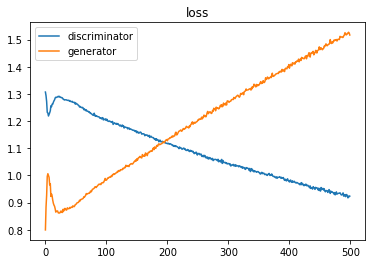

In [12]:
draw(errors_d, errors_g)

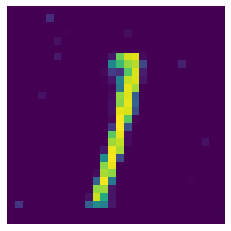

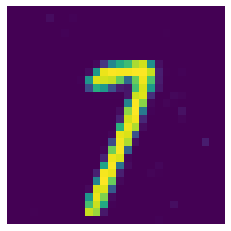

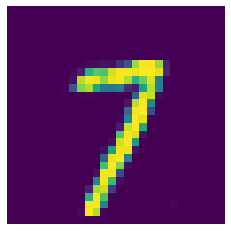

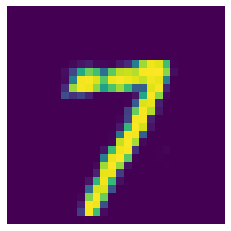

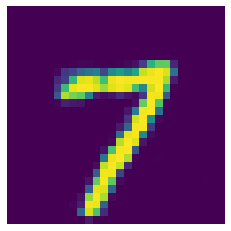

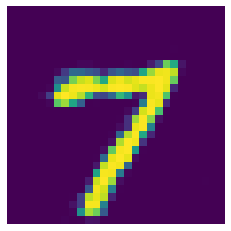

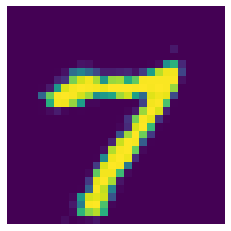

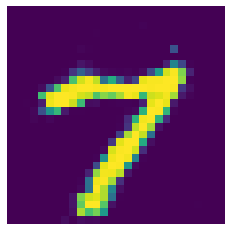

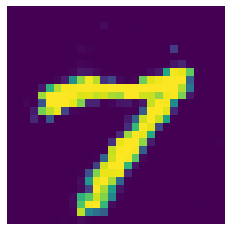

In [13]:
model = Generator().to(device)
model.load_state_dict(torch.load('checkpoints/generator.pkl'))
model.eval()
noise0 = torch.zeros(1, latent_dim).to(device)
noise1 = torch.ones(1, latent_dim).to(device)
noises = [noise0]
for i in range(1, 8):
    alpha = i / 8
    noise = alpha * noise1 + (1 - alpha) * noise0
    noises.append(noise)
noises.append(noise1)
for noise in noises:
    with torch.no_grad():
        fake = model(noise)
    fake = fake.view(-1, 1, 28, 28)
    plt.imshow(np.transpose(fake.cpu().numpy()[0], (1, 2, 0)))
    plt.axis('off')
    plt.show()
